# Курсовая по курсу Data Science (второй проход)

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)

# input
DATASET_PATH = 'course_project_train.csv'
DATASET_TEST_PATH = 'course_project_test.csv'

# output
#PREP_DATASET_PATH = '../training_project_data_prep.csv'

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [4]:
df = pd.read_csv(DATASET_PATH)
df_test = pd.read_csv(DATASET_TEST_PATH)

In [5]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


Все строки с типом объект приведем к типу строка

In [7]:
#for colname in df.select_dtypes(include=['object']).columns:
    #print(colname)
#    df[colname] = df[colname].astype(str)
    #сразу сделаем и для второго набора
#    df_test[colname] = df_test[colname].astype(str)

Тут функции у нас будут с помощью которых мы будем обрабатывать наши колонки и приводить их к нужному виду

In [8]:
 def my_prepare_dataset(cdf, col):
    if (col == 'Home Ownership'):
        # прировняем 'Home Mortgage' к "Have Mortgage".
        cdf.loc[cdf[col] == 'Have Mortgage', col] = 'Home Mortgage'
    elif (col == 'Annual Income'):
        #Обрабатываем годовой доход        
        #Добавим свою колонку с полему указан доход или нет 
        cdf.loc[cdf[col].isnull() , 'Revenue set'] = 0
        cdf.loc[cdf[col] == 0 , 'Revenue set']     = 0
        
        cdf.loc[cdf[col] > 0 , 'Revenue set']     = 1
        
        #и заменим сам доход с NaN на 0
        cdf.loc[cdf[col].isnull() , col] = 0
        
        cdf['Revenue set'] = cdf['Revenue set'].astype('int32')
    elif (col == 'Years in current job'):
        #Ставим значения на месте работы, на моду, но только там, где указан годовой доход
        cdf.loc[(cdf[col].isnull()) & (cdf['Annual Income']==0), col] = '-1'
        cdf.loc[(cdf[col].isnull()) & (cdf['Annual Income']>0) , col] = cdf[col].mode()[0]
         
        #Подготовим данные для преобразования в число
        cdf.loc[cdf[col] == '< 1 year', col] = '0 year';
        
        #Теперь заменим года, чтобы перейти на числове значений
        cdf[col] = cdf[col].astype(str)
        cdf[col] = pd.to_numeric(cdf[col].str.replace(r'[^0-9\-]', ''), errors='coerce') 
        cdf[col] = cdf[col].astype('int32')
    elif (col == 'Tax Liens'):
        #cdf.loc[cdf[col]>=1, col] = 0
        pass
    elif (col == 'Maximum Open Credit'):
        cdf['Debt load'] = 0
        cdf.loc[cdf['Annual Income']>0 , 'Debt load'] = cdf.loc[cdf['Annual Income']>0 , 'Maximum Open Credit']/cdf.loc[cdf['Annual Income']>0 , 'Annual Income'] 
    elif (col == 'Number of Credit Problems'):
        pass
    elif (col == 'Months since last delinquent'):
        cdf.loc[cdf[col].isnull() , col] = 0
    elif (col == 'Bankruptcies'):
        cdf.loc[cdf[col].isnull() , col] = cdf[col].mode()[0]
        
        #И ещё добавим све поле, которое будет делить всё просто на два класса
        cdf['Bankruptcies Flag'] = 1
        cdf.loc[cdf[col] == cdf[col].mode()[0] , 'Bankruptcies Flag'] = 0
    elif (col == 'Purpose'):
        if col in cdf:
            # Если надо, то сделаем слияние маленьких признаков
            if not('All others' in cdf[col].value_counts()):
                # Значит нет ещё моего признака, и нужно сделать обработку
                tmp_values = dict(cdf['Purpose'].value_counts().copy())

                for i in range(4,len(tmp_values)):
                    cdf.loc[cdf[col] == list(tmp_values.keys())[i] , col] = 'All others'
                    #print (list(tmp_values.keys())[i])
    elif (col == 'Term'):
        tmp_values = dict(cdf['Term'].value_counts().copy())
        
        cdf.loc[cdf[col] == list(tmp_values.keys())[0] , col] = 0
        cdf.loc[cdf[col] == list(tmp_values.keys())[1] , col] = 1
        
        cdf[col] = cdf[col].astype('int32')
    elif (col == 'Current Loan Amount'):
        pass
    elif (col == 'Credit Score'):
        #Добавим свое поле с тремя значениями, -1 кредитного рейтинга нет, 0 - рейтинг близко к нулю, и 1-высокий 
        #порог отсечения пока условный в 32 пнукта
        if not('Credit Score My flag' in cdf):
            cdf['Credit Score My flag'] = 1
            cdf.loc[cdf[col].isnull() , 'Credit Score My flag'] = -1
            cdf.loc[cdf[col]<=10 , 'Credit Score My flag'] = 0
        
        #И теперь заменяем пропуски в самой выборке
        cdf.loc[cdf[col].isnull() , col] = 0

## Обзор данных и их предобработка

### 1. Home Ownership

По количеству всё хорошо, но вот только смущает что "Have Mortgage" и "Home Mortgage". И то и другое про ипотеку, потому - прировняем 'Home Mortgage' к "Have Mortgage".

In [9]:
my_prepare_dataset(df,'Home Ownership')
my_prepare_dataset(df_test,'Home Ownership')

### 2.  Annual Income
Тут просто убираем пропуски NaN, пока не делал. пропустил. Кроме того, там есть достачтоно много пропусков

In [10]:
#(len(df['Annual Income']) - df['Annual Income'].count())/len(df)*100
#(len(df_test['Annual Income']) - df_test['Annual Income'].count())/len(df_test)*100
my_prepare_dataset(df,'Annual Income')
my_prepare_dataset(df_test,'Annual Income')

>20 процентов пропусков причем в обоих выборках. Кондидат на исключение. Особенно так как много разных значения и разброс достаточно большой

Добавил новое поле ещё <b>Revenue set</b>, которое принимает 0, если цифра дохода не указана и 1 если доход указан

### 3. Years in current job

In [11]:
my_prepare_dataset(df,'Years in current job')
my_prepare_dataset(df_test,'Years in current job')

In [12]:
df['Years in current job'].value_counts()

 10    2628
 2      705
 3      620
 0      563
 5      516
 1      504
 4      469
 6      426
 7      396
 8      339
 9      259
-1       75
Name: Years in current job, dtype: int64

>Будем менять на моду, все nan пока не сделал

В итоге сделал не совсем так. Поменял на моду но только там где есть годовой доход. Было бы странно указавать значение 10+ для таких случаев, так как вдруг например нет формальной работы или дохода или ещё что-то. 
Кроме того, я поддерживую мысль того чтобы не делать прям толпу дами перменных, потому преревел всё в число, и так как есть значения <1 то 0 превратил в -1

### 4. Tax Liens

In [13]:
my_prepare_dataset(df,'Tax Liens')
my_prepare_dataset(df_test,'Tax Liens')
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

>Вот как раз пример несбалансированных данных. Есть идея превратить его в несколько значений. Типа всех с 0 - в одну, а остальные в другую группу. Может быть с промежуточным значением. Пока не делал.

В итоге подготовил в функции место для преобразования. Но оставил сеййчас как есть, чтобы посмотреть дальше, вдруг этот показатель сильно коррелирует с нашей целеовой переменной.

### 5. Number of Open Accounts

In [14]:
#df['Number of Open Accounts'].value_counts()
#df_test['Number of Open Accounts'].value_counts()

Думаю что можно все оставить как есть. Может выбросы убрать потом.

### 6. Years of Credit History

In [15]:
#df['Years of Credit History'].value_counts()
#df_test['Years of Credit History'].value_counts()

Пока тоже вроде всё ок

### 8. Maximum Open Credit

In [16]:
my_prepare_dataset(df,'Maximum Open Credit')
my_prepare_dataset(df_test,'Maximum Open Credit')

In [17]:
#df.loc[df['Debt load']==0]

>С пропусками ок. Возникла мысль, взять не это поле как есть, а как отношение этого поля к доходу. Возможно оно будет интересннесе, для прогнозирования, возможно с ранжированием. Чтобы перейти от абсолютных значений и невелировать небольшие расхождения в суммах.
Строю такие предположения, так как считаю что такие показатели +/- 100 в реальной жизни не влияют на показатель, а скорее могу давать не правильный прогноз

Появилось новое поле <b>Debt load</b> как отношение кредитов к годовому доходу, если годовой доход есть

### 8. Number of Credit Problems

In [18]:
#my_prepare_dataset(df,'Number of Credit Problems')
#my_prepare_dataset(df_test,'Number of Credit Problems')

In [19]:
#df['Number of Credit Problems'].value_counts()
#df_test['Number of Credit Problems'].value_counts()

Пока предпологаю оставить как есть. Но вообще хочется конечно тоже немного свести к более категорийным. Но время покажет :)

### 9. Months since last delinquent

In [20]:
my_prepare_dataset(df,'Months since last delinquent')
my_prepare_dataset(df_test,'Months since last delinquent')

In [21]:
#(len(df['Months since last delinquent']) - df['Months since last delinquent'].count())/len(df)*100
#(len(df_test['Months since last delinquent']) - df_test['Months since last delinquent'].count())/len(df_test)*100

>Да вот оно странное поле. С одной стороны оно должно быть показательным. С другой стороны у нас есть 50 процентов пропусков. Мы не знаем почему - так. В нормальной ситуации можно предположить,что отсутсвие этих данных - это наверное хорошо. Так как мы рассматриваем именно месечный платеж, а не допустим банкротсов и не возврат кредита. Исключать наверное нельзя, так как если 60 раз до этого была просрочка то с высокой вероятностью кажется что и в этот раз будет
Потому, наверное, заполним нулями все пустые.  

Пока просто заполнил пропуси нулями. Считаем что если нет данных, то пропусков не было

### 10. Bankruptcies

In [22]:
my_prepare_dataset(df,'Bankruptcies')
my_prepare_dataset(df_test,'Bankruptcies')

In [23]:
#(len(df['Bankruptcies']) - df['Bankruptcies'].count())/len(df)*100
#(len(df_test['Bankruptcies']) - df_test['Bankruptcies'].count())/len(df_test)*100
df['Bankruptcies Flag'].value_counts()

0    6674
1     826
Name: Bankruptcies Flag, dtype: int64

>Пропусков мало, потому будем заменять их нулевыми значениями. Мне конечно хочется очень тоже заменять его на булево. Но будет видно после первой модели.

Так и сделал, заменил на моду все пропуски. И ещё добавил <b>Bankruptcies Flag</b> которое просто 0 или 1. 1 всё что не 0 в Bankruptcies

### 11. Purpose

In [24]:
my_prepare_dataset(df,'Purpose')
my_prepare_dataset(df_test,'Purpose')

In [25]:
if 'Purpose' in df:
    df = pd.get_dummies(df, prefix='Purpose', columns=['Purpose'], dtype=int)

if 'Purpose' in df_test:
    df_test = pd.get_dummies(df_test, prefix='Purpose', columns=['Purpose'], dtype=int)
    

In [26]:
#df['Purpose'].value_counts()
#df_test['Purpose'].value_counts()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 24 columns):
Home Ownership                  7500 non-null object
Annual Income                   7500 non-null float64
Years in current job            7500 non-null int32
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    7500 non-null float64
Bankruptcies                    7500 non-null float64
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7500 non-null int64
Revenue set                     750

>Пропусков нет - уже хорошо. Это поле точно нужно превращать в что-то более просто. Всё что не в TOP преврщать в other, но дальше модель покажет.

Сделал слияние всех признаков которые меньше определенного порога, можно будет подвигать. Ну и сделал преврашение в DUMMY

### 11. Term

In [28]:
my_prepare_dataset(df,'Term')
my_prepare_dataset(df_test,'Term')

In [29]:
df['Term'].value_counts()
#df_test['Term'].value_counts()

0    5556
1    1944
Name: Term, dtype: int64

>Всё красиво, пропусков нет. Идеально заменится одной переменной со значением 0/1

Так и сделал

### 12. Current Loan Amount

In [30]:
#my_prepare_dataset(df,'Current Loan Amount')
#my_prepare_dataset(df_test,'Current Loan Amount')

In [31]:
#df['Current Loan Amount'].value_counts()
#df_test['Current Loan Amount'].value_counts()

>Конечно смущает больше кол-во значений с 999... в реале будто при выгрузке попало в переменную меньшей длинны, и потому обрезалось. Видимо так и оставляем, так как нам с этим ничего не сделать

Так и сделал

### 13. Current Credit Balance

In [32]:
#df['Current Credit Balance'].value_counts()
#tmp_df = df.loc[df['Current Credit Balance']==0]
#tmp_df

>Немного смущают 0, хотя их и не много. Так как если он ноль, то и кредита значит нет, и строчек тут этих быть не должно. Потому посмотрю уже предметно на сами записи эти. Возможно что просто буду их игнорировать все строки с нулевым остатком. 

Не стал ничего с ними делать в итоге, так как яркого ничего не увидел, при этом прям несколько записей были с не нулевой нашей целевой переменной. 

### 14. Monthly Debt

In [33]:
#df['Monthly Debt'].value_counts()
tmp_df = df.loc[(df['Current Credit Balance']==0) & (df['Monthly Debt']==0)]
tmp_df


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Revenue set,Debt load,Bankruptcies Flag,Purpose_All others,Purpose_business loan,Purpose_debt consolidation,Purpose_home improvements,Purpose_other
780,Home Mortgage,867749.0,10,0.0,2.0,16.5,0.0,0.0,66.0,0.0,0,75350.0,0.0,0.0,704.0,0,1,0.0,0,0,0,0,1,0
1643,Rent,0.0,9,0.0,3.0,10.0,0.0,0.0,0.0,0.0,0,332156.0,0.0,0.0,NaN,1,0,0.0,0,0,0,0,0,1
3219,Home Mortgage,0.0,10,0.0,3.0,18.5,0.0,0.0,0.0,0.0,0,79200.0,0.0,0.0,NaN,0,0,0.0,0,0,0,1,0,0
3496,Rent,233567.0,1,0.0,7.0,11.7,0.0,0.0,0.0,0.0,0,210166.0,0.0,0.0,746.0,0,1,0.0,0,1,0,0,0,0
4165,Rent,1254513.0,10,0.0,6.0,23.4,0.0,0.0,60.0,0.0,0,99999999.0,0.0,0.0,748.0,0,1,0.0,0,1,0,0,0,0
7124,Rent,0.0,1,0.0,4.0,11.0,0.0,0.0,50.0,0.0,0,134024.0,0.0,0.0,NaN,0,0,0.0,0,0,0,1,0,0


In [34]:
tmp_df = df_test.loc[(df_test['Current Credit Balance']==0) & (df_test['Monthly Debt']==0)]
tmp_df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Revenue set,Debt load,Bankruptcies Flag,Purpose_All others,Purpose_buy a car,Purpose_debt consolidation,Purpose_home improvements,Purpose_other


>Тоже немного смущают нули, посмотрю прям по строчкам. Возможно это теже строки где нули в общем теле кредита. И тогда точно их уберу

Посмотрел на них, пока удялть не стал. Конечно не тяжело когда у тебя только датасет и нет данных о том как и кто собирал (
Пока не удолял

### 15. Credit Score

In [35]:
#df['Credit Score'].value_counts()
#df_test['Credit Score'].value_counts()
my_prepare_dataset(df,'Credit Score')
my_prepare_dataset(df_test,'Credit Score')

In [36]:
#(len(df['Credit Score']) - df['Credit Score'].count())/len(df)*100
#(len(df_test['Credit Score']) - df_test['Credit Score'].count())/len(df_test)*100

>Нет в описании этого поля. Кредитный рейтинг это судя по всему. У меня лично нет к нему доверия (и тут в этом дата сете в том числе) так как методики нет. Наверное буду пробовать строить модель и учетом этого рейтинга и без него, чтобы сравнить. Возможно добавлю ещё поле бинарное. Есть рейтинг 0/1 и посмотрю что будет

Заменил пропуски в самом поле и добавил свой рейтинг в котором -1, если его нет - 0, если он не выше порога определнного и 1 если выше этого порога

In [37]:
df['Credit Score My flag'].value_counts()

 1    5943
-1    1557
Name: Credit Score My flag, dtype: int64

## Смотрим уже предметно показатели

### "Credit Default". Собсвтенно наша целевая переменная

In [38]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

На всякий случай посмотрел что нет значений других кроме 0 и 1 :)

In [39]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

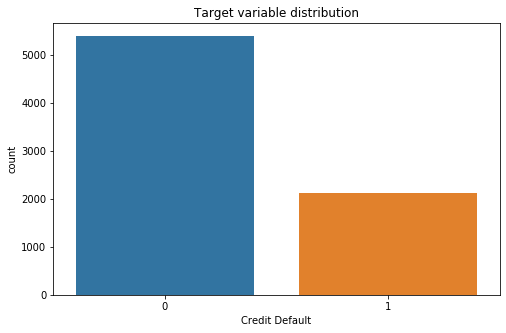

In [40]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df)

plt.title('Target variable distribution')
plt.show()

Дисбаланс у нас тут тоже есть, как и в уроке. Что понятно. На сколько я понял, такой дисбаланс говорить нам о том, что "легче" будет предсказать 0 чем 1. И опять таки, на сколько я понял, нам это нужно прежде всего для того чтобы понимать как раз для того, чтобы потом "двигать" F-функцию

Так, посмотрим на то, какие показатели будут коллерировать с нашей целевой переменной

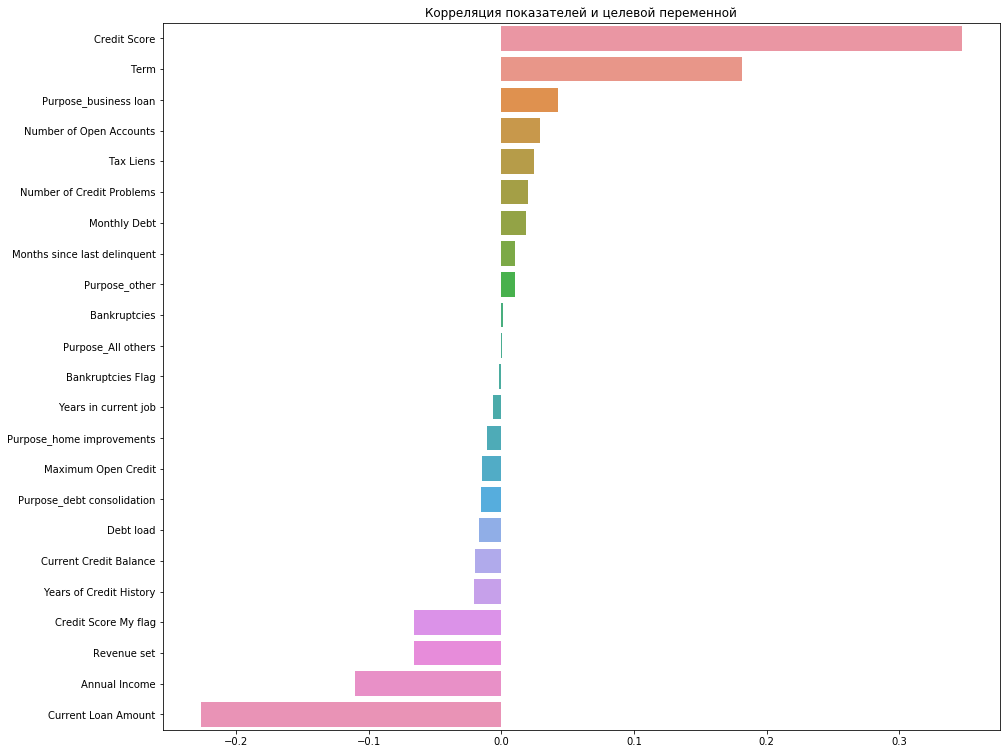

In [41]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(15, 13))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция показателей и целевой переменной')
plt.show()

Вот у нас выделились явные лидеры, которые нам надо рассмотреть: Credit Score и Term с положительной корреляцией и Credit Score My Flag, Revenue Set, Annual Income, Curent Loan Amount -  с отрицательной

Потому смотрим на каждый из них в отдельности

### Оценка признака "Credit Score" в разрезе целевой переменной

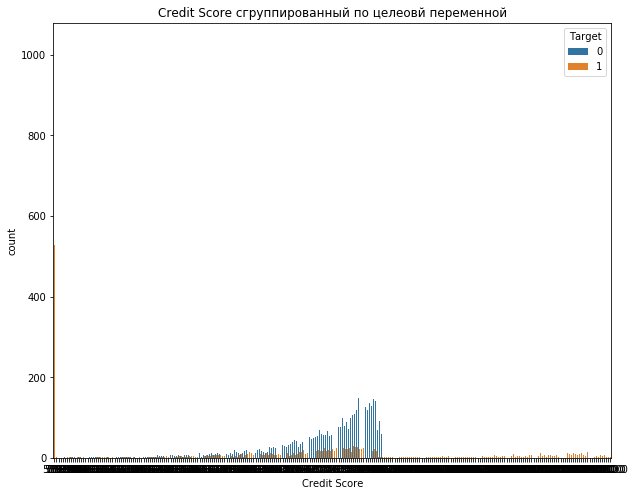

In [42]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Credit Score", hue=TARGET_NAME, data=df)
plt.title('Credit Score сгруппированный по целеовй переменной')
plt.legend(title='Target', loc='upper right')

plt.show()

Так как у нас там много разных значений, то для визульного анализа будем использовать другой метод. Туд ничего не видно :)

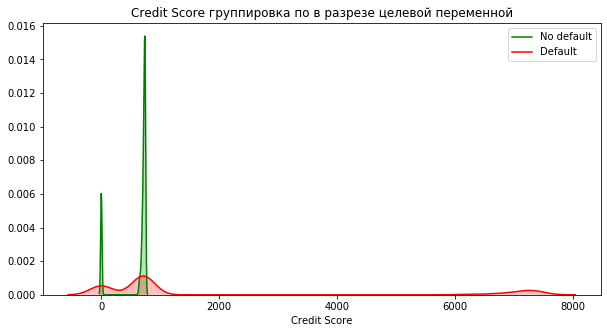

In [43]:
#Получили сулчайную выборку строк и по двум колонкам
sc_with_target_s = df[['Credit Score', TARGET_NAME]].sample(1000)
sc_s = sc_with_target_s['Credit Score']

# разделили значения по двум графикам 
sc_target_0 = sc_s[sc_with_target_s[TARGET_NAME] == 0]
sc_target_1 = sc_s[sc_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(sc_target_0, shade=True, label='No default', color='g')
sns.kdeplot(sc_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score группировка по в разрезе целевой переменной')
plt.show()

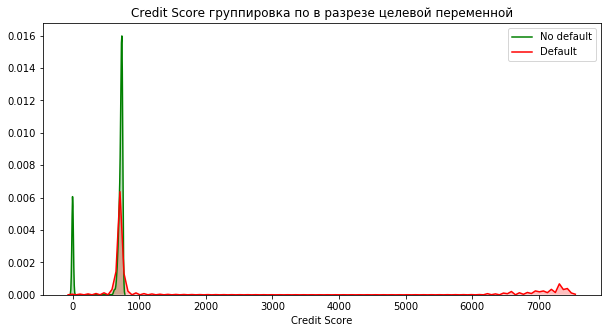

In [44]:
sc_with_target_s = df[['Credit Score', TARGET_NAME]].sample(1000)
sc_s = sc_with_target_s['Credit Score']
sc_target_0 = sc_s[sc_with_target_s[TARGET_NAME] == 0]
sc_target_1 = sc_s[sc_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(sc_target_0, shade=True, label='No default', color='g')
sns.kdeplot(sc_target_1, shade=True, label='Default', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score группировка по в разрезе целевой переменной')
plt.show()

Зафиксировал несколько разных семплов, они показательны как раз.
На сколько я понимаю, это не безумно хорошо, так как по вертикали у нас частота, то нам их сложно будет разделить.
Не считая правого всплеска, можно было бы попытаться разбить на два отдельных множества, которые были бы а-ля нормальные, но тоже не вижу что это даст, так как не поможет задачи классификации этого признака 

Но, возможно я не прав, и не так трактую график, потому проверим этот показатель как делали в уроке
Сначала проверим на нормальность, для успокоения души

In [45]:
shapiro(sc_s)

(0.38174968957901, 0.0)

Вот с гипотезами пока как то тяжко, видимо надо вертеть эти данные вкуча разрезах, чтобы и проверять чуть ли не по всем критерям, чтобы найти что-то. Но вот что, с мат ожиданием понятно. Если у нас будет два разных мат ожидания для двух этих классов, то когда прилетит значение этой переменной, мы сможем с уверенноостью в 95 процентов сказать как это повлияете на целевую переменную

Какие ещё могут быть гипотезы, пока сложно предположить. Потому как тут визуально матожидания будут где-то рядом.

#### Наблюдение
Визуально различия есть, проверяем, мат ожидания у них будут равны или нет 

#### Гипотеза

* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: с помощью критерия Манна-Уитни
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни

In [46]:
mannwhitneyu(sc_target_0, sc_target_1)

MannwhitneyuResult(statistic=100271.0, pvalue=0.38640661859437847)

pvalue получилось не сильно меньше даже больше ) видимо не очень хорошо ) посмотрим тоже на графике

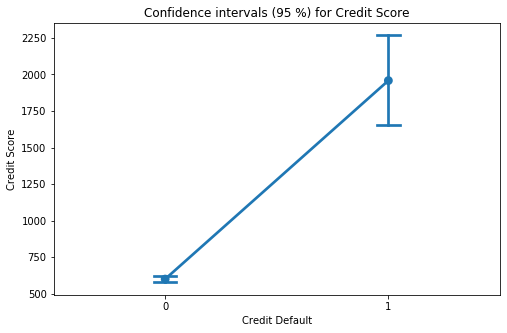

In [47]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=sc_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

Так, а вот по графику, всё получается прям ну очень хорошо. Получается мы можем отвергунть нулевую гипотезу, о том что мат ожидания равны, так как у них не плохой разброс 

<b>Вопрос</b>:Гипотеза могла же быть и наоборот высказана, нулевая гепотеза могла быть названа "Мат ожидания не равны", уровень значимости наверное тогда был 0.95? Но что от этого поменялось, выборка была таже, mannwhitneyu вернул бы теже значения. Возможно их интерпритировать нужно было бы по другому. И визуально график бы не поменялся, так как мы просто раздили имеющиеся у нас данные. Потому совсем пока не понял зачем мне нужна была гипотеза :(

#### Оценка признака "Term" в разрезе целевой переменной

In [48]:
df['Term'].value_counts()

0    5556
1    1944
Name: Term, dtype: int64

Он у нас всего из двух значений, занчит его посмотрим как раз в частоном разрезе

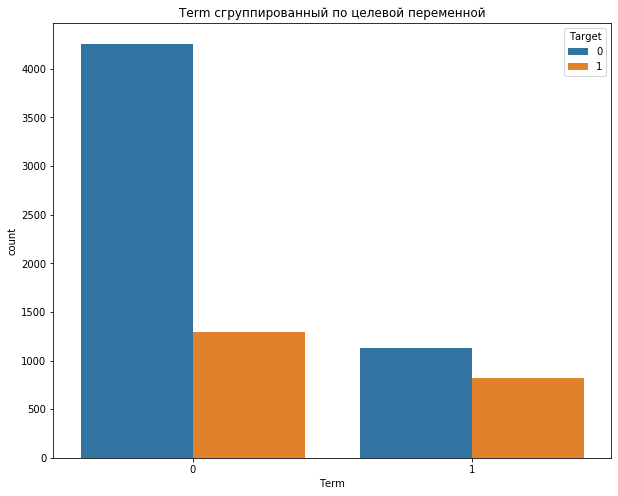

In [49]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Term", hue=TARGET_NAME, data=df)
plt.title('Term сгруппированный по целевой переменной')
plt.legend(title='Target', loc='upper right')

plt.show()

Видно что высокий процент Term=1 превращает нашу целевую переменную. Это хорошо, какие-то доп оценки видимо делать нет смысла

#### Оценка признака "Term" в разрезе целевой переменной

In [51]:
df['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

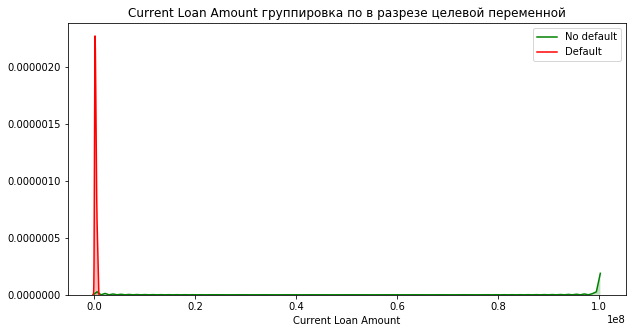

In [55]:
#Получили сулчайную выборку строк и по двум колонкам
cla_with_target_s = df[['Current Loan Amount', TARGET_NAME]].sample(1000)
cla_s = cla_with_target_s['Current Loan Amount']

# разделили значения по двум графикам 
cla_target_0 = cla_s[cla_with_target_s[TARGET_NAME] == 0]
cla_target_1 = cla_s[cla_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(cla_target_0, shade=True, label='No default', color='g')
sns.kdeplot(cla_target_1, shade=True, label='Default', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount группировка по в разрезе целевой переменной')
plt.show()

In [57]:
shapiro(cla_s)

(0.35864561796188354, 0.0)

Распределение не нормальное, посмотрим в этот раз визально, как в уроке.

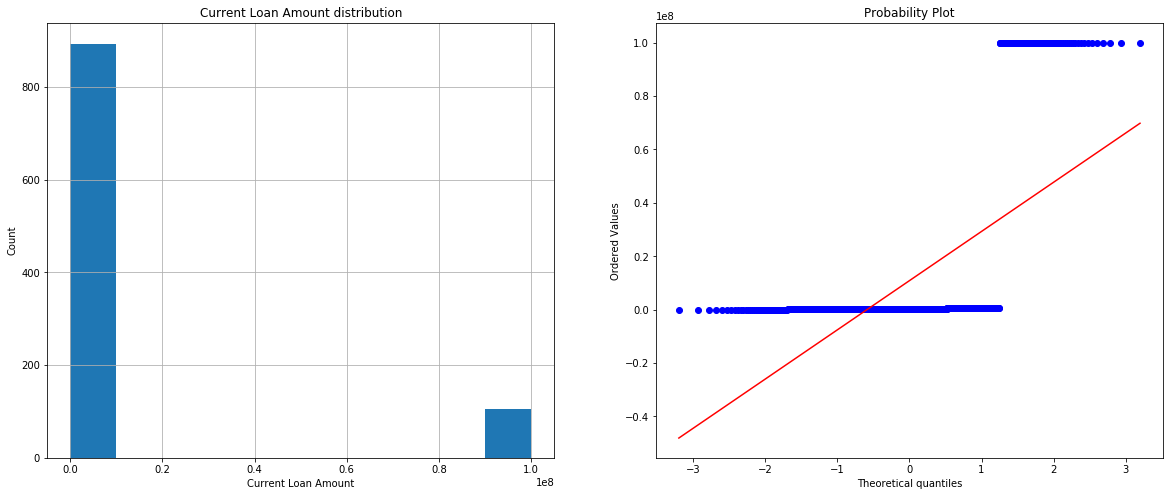

In [59]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current Loan Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current Loan Amount distribution')
cla_s.hist()

plt.subplot(122)
probplot(cla_s, dist='norm', plot=plt)

plt.show()

Хорошее распределение для разделения судя по графику

#### Оценка признака "Term" в разрезе целевой переменной

In [62]:
df['Annual Income'].value_counts()

0.0          1557
1161660.0       4
1058376.0       4
1043651.0       4
1338113.0       4
             ... 
1141254.0       1
7907382.0       1
1534478.0       1
972040.0        1
585751.0        1
Name: Annual Income, Length: 5479, dtype: int64

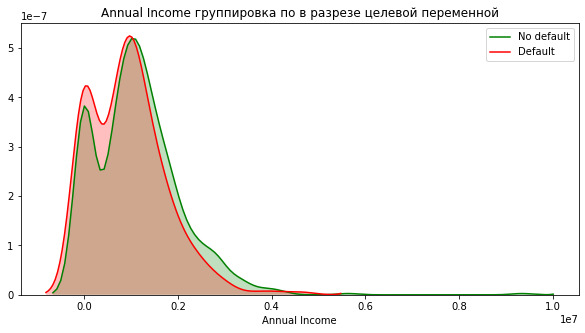

In [65]:
#Получили сулчайную выборку строк и по двум колонкам
ai_with_target_s = df[['Annual Income', TARGET_NAME]].sample(1000)
ai_s = ai_with_target_s['Annual Income']

# разделили значения по двум графикам 
ai_target_0 = ai_s[ai_with_target_s[TARGET_NAME] == 0]
ai_target_1 = ai_s[ai_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(ai_target_0, shade=True, label='No default', color='g')
sns.kdeplot(ai_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income группировка по в разрезе целевой переменной')
plt.show()

Кажется очень похожими, посмотрим что там с мат ожиданиями

In [67]:
mannwhitneyu(ai_target_0, ai_target_1)

MannwhitneyuResult(statistic=90994.0, pvalue=0.0003827293700265393)

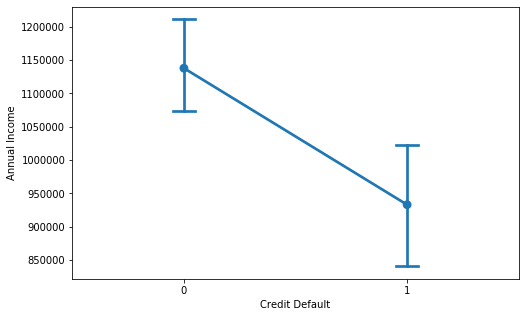

In [68]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=ai_with_target_s, capsize=.1)

##plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

#### Оценка признака "Revenue set" в разрезе целевой переменной

In [72]:
df['Revenue set'].value_counts()

1    5943
0    1557
Name: Revenue set, dtype: int64

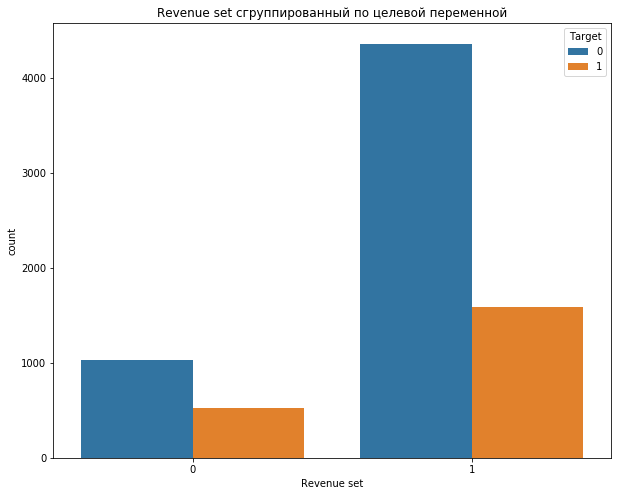

In [73]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Revenue set", hue=TARGET_NAME, data=df)
plt.title('Revenue set сгруппированный по целевой переменной')
plt.legend(title='Target', loc='upper right')

plt.show()

Ну вот такое влияние этой переменной на целевую переменную. Не вижу что тут можно и навреное и не нужно делать ничего  

P.S. Смотрю третью видео, надеюсб продвинусь дальше сильнее 